Saving creditcard.csv.csv to creditcard.csv.csv
✅ Dataset Loaded. Shape: (690, 16)


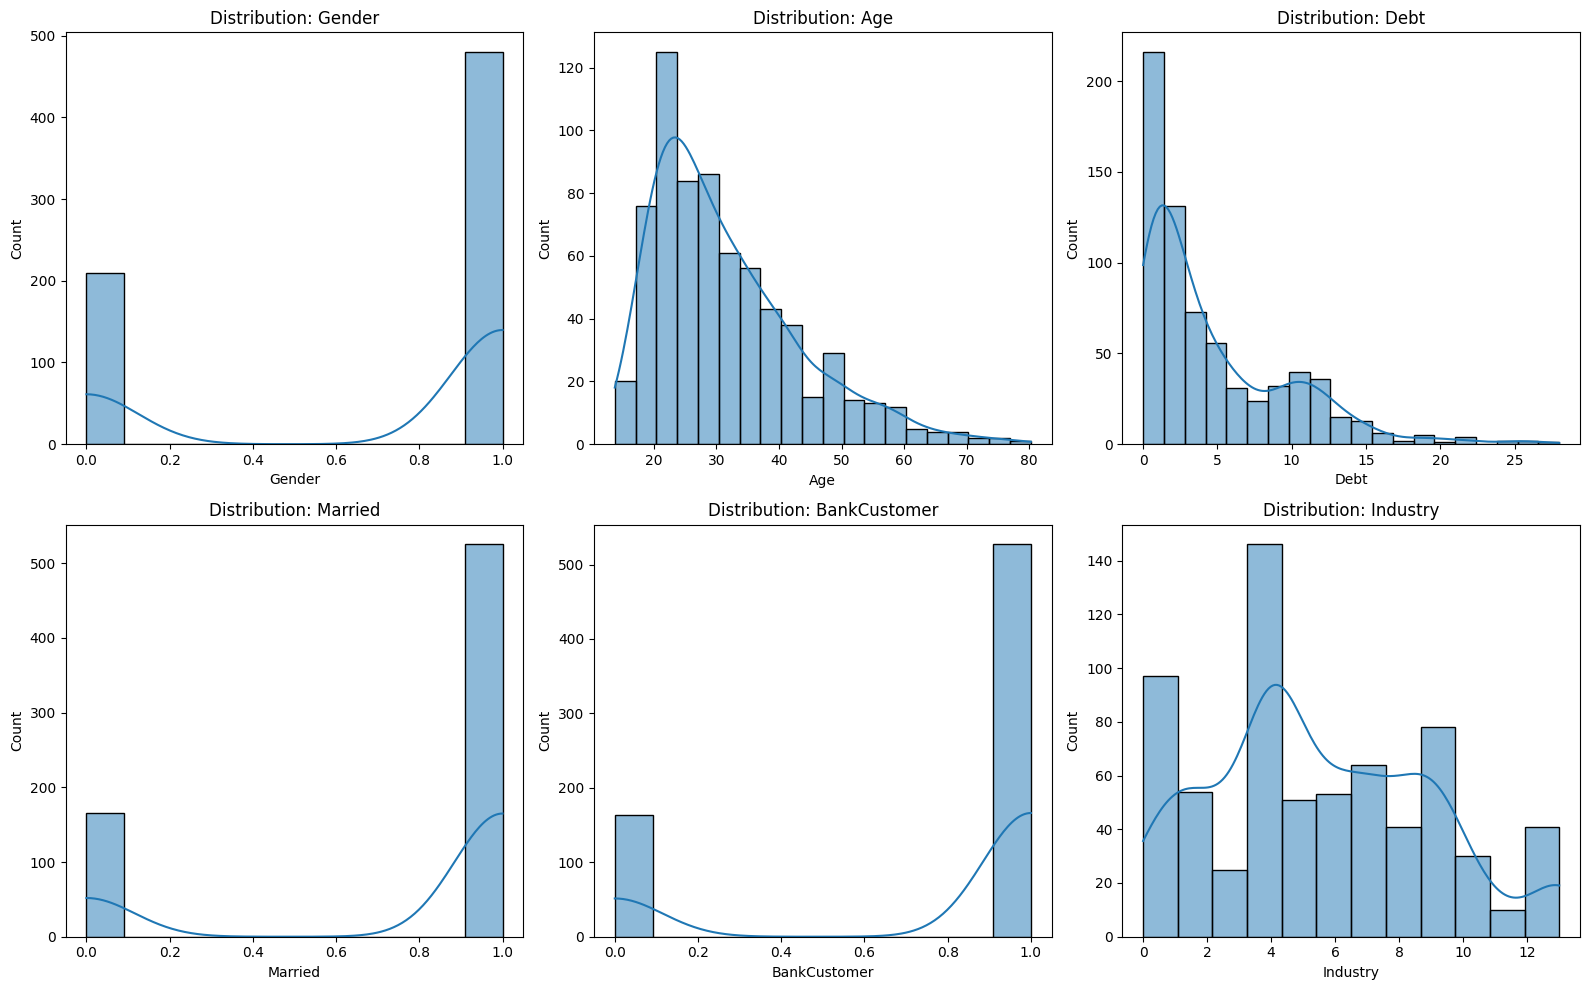

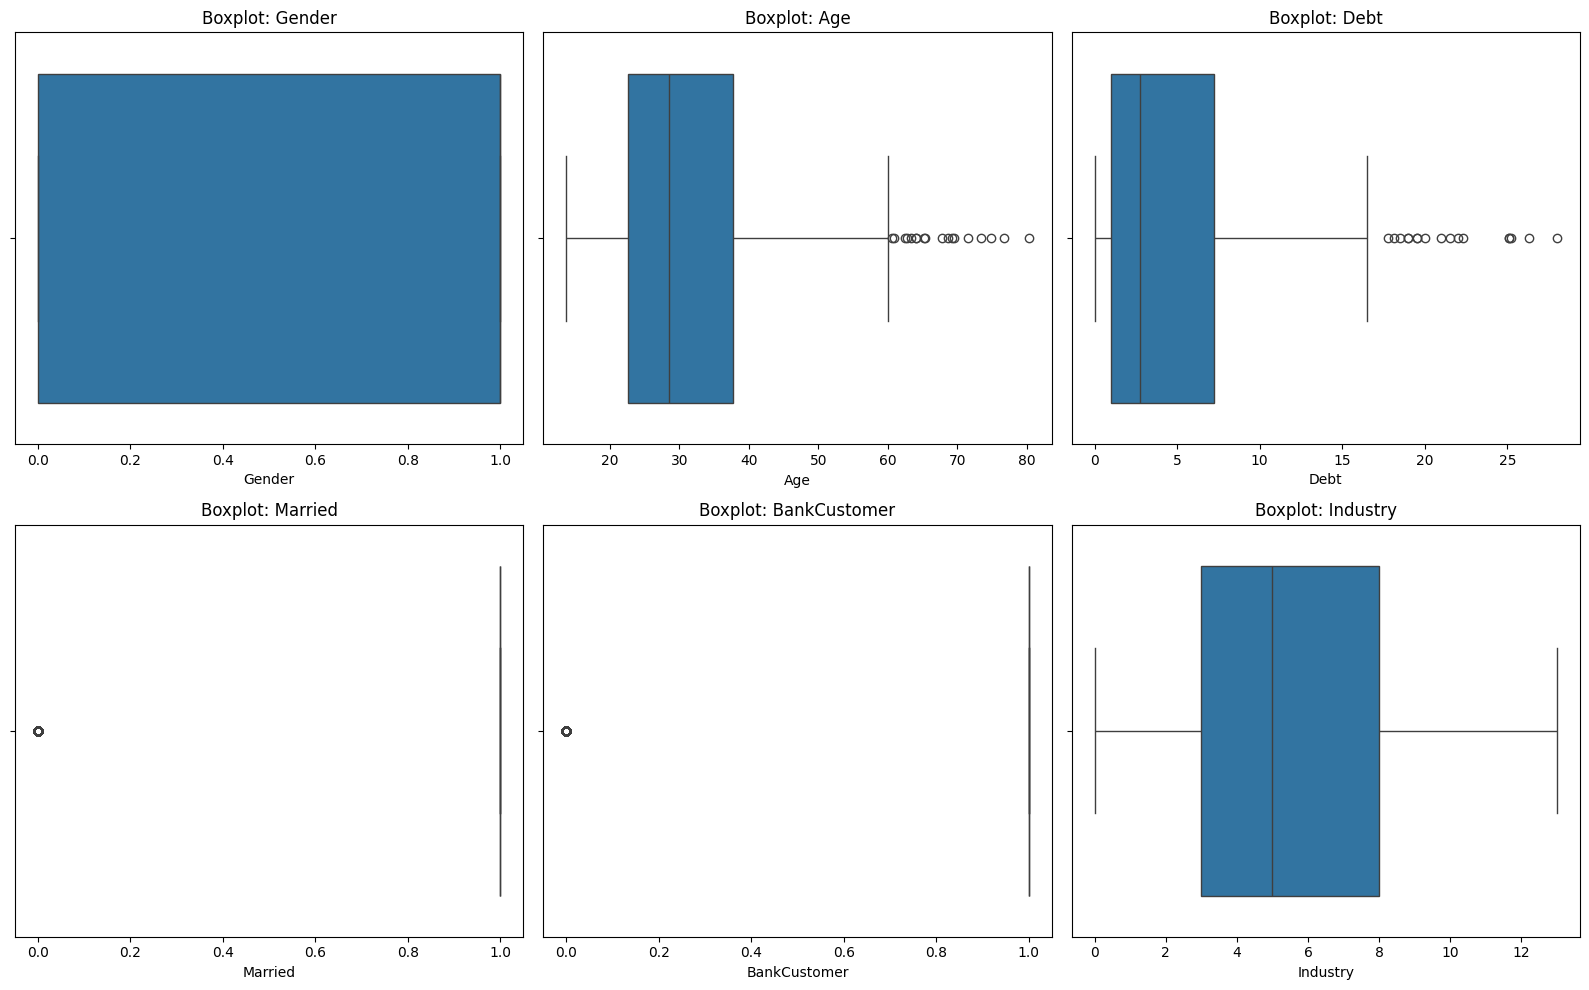

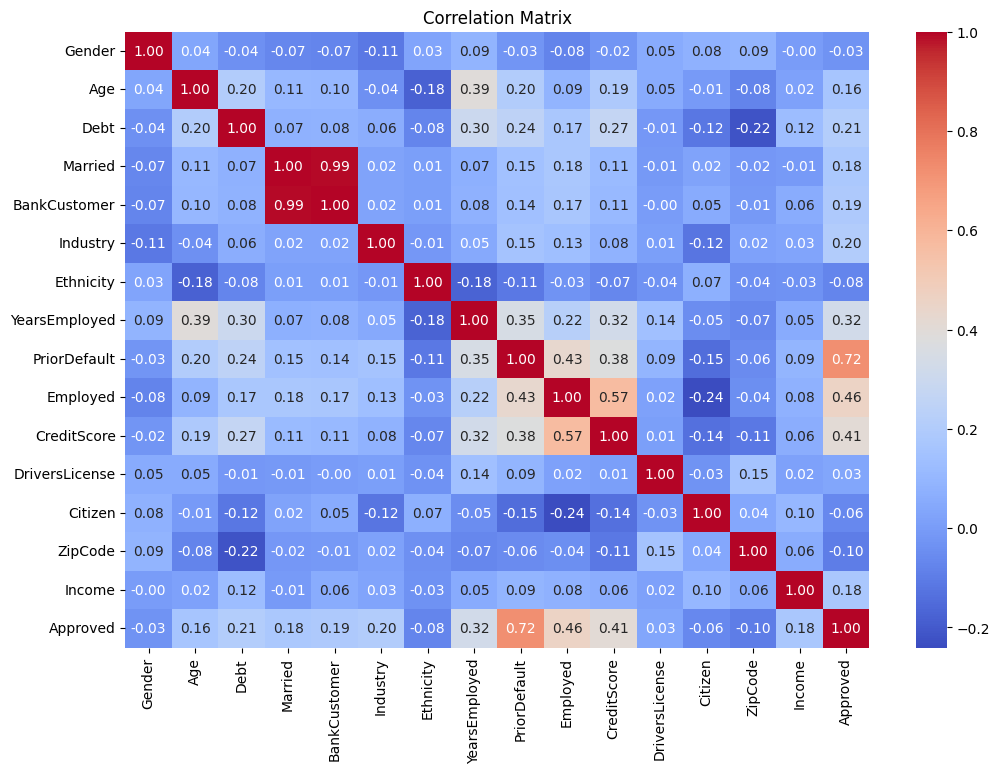

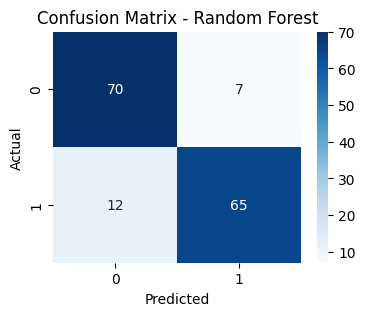

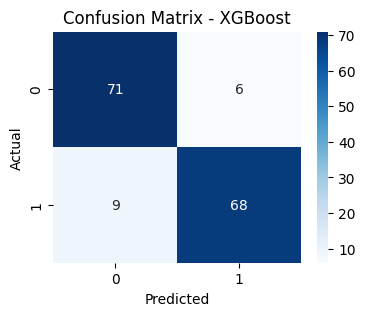

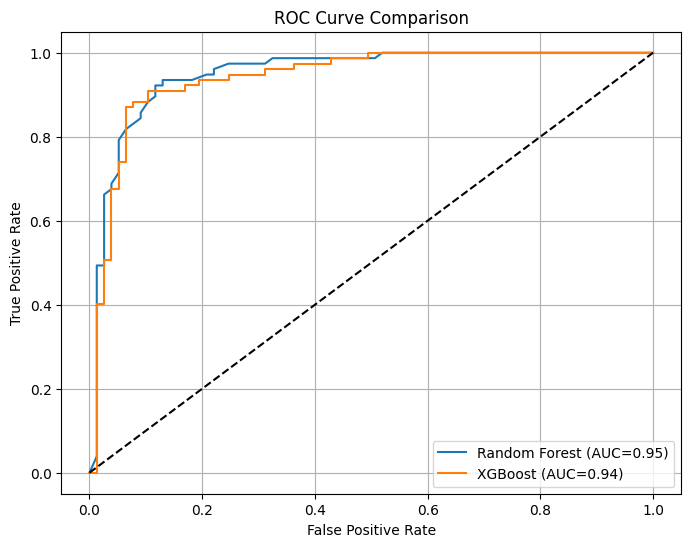

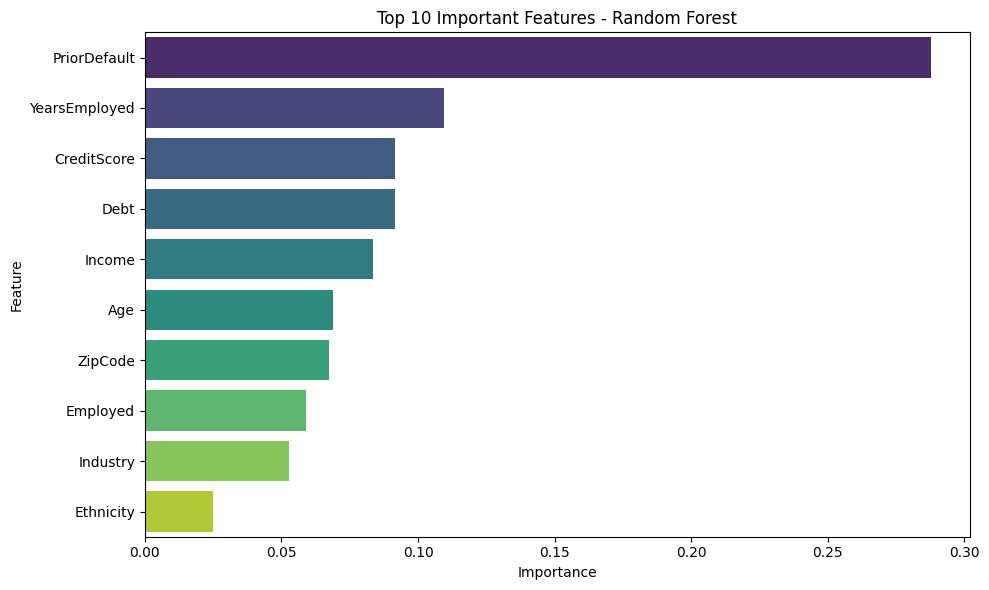

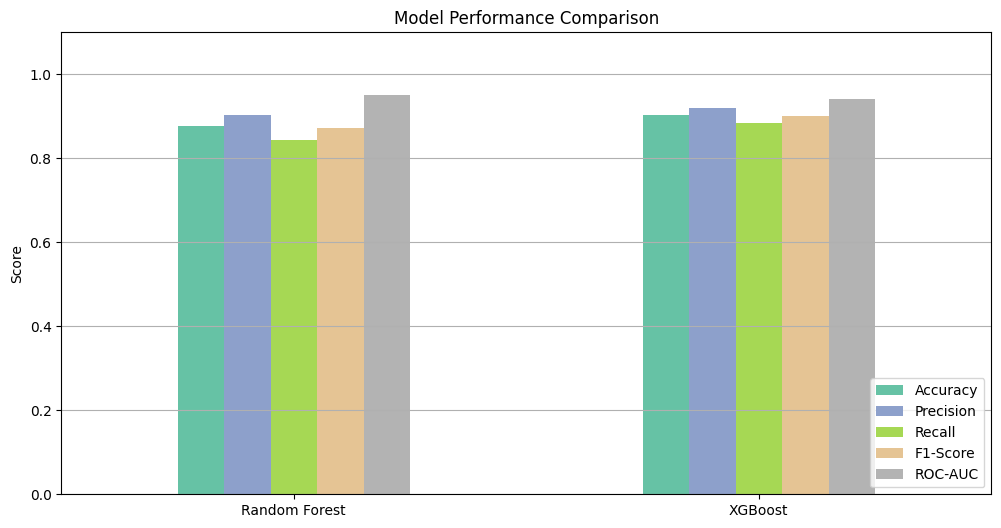

In [1]:
!pip install -q imbalanced-learn xgboost

# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder # Import LabelEncoder here
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_score, recall_score, f1_score, accuracy_score
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# 📂 Upload and read dataset
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(filename)

# ✅ Verify target column
if 'Approved' not in df.columns:
    raise ValueError("Expected target column 'Approved' not found.")

print("✅ Dataset Loaded. Shape:", df.shape)
# 🔄 Convert categorical features to numerical using Label Encoding
for col in df.select_dtypes(include=['object']).columns: #loop through all object type(categorical) columns
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col]) #fit and transform on the column
# 🔍 Univariate EDA
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()

# 🔍 Box plots
plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

# 🔍 Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# ⚙️ Preprocessing
df.drop_duplicates(inplace=True)

# Normalize numerical columns (excluding target)
scaler = StandardScaler()
features = df.select_dtypes(include=[np.number]).columns.difference(['Approved'])
df[features] = scaler.fit_transform(df[features])

# 🧪 Features & Target
X = df.drop(columns=['Approved'])
y = df['Approved']

# ⚖️ Balance with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# 🔪 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# 🤖 Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}
results = {}

# 🏋️ Training
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }

# 📊 Confusion Matrix
for name, res in results.items():
    plt.figure(figsize=(4, 3))
    sns.heatmap(res["conf_matrix"], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 📈 ROC Curve
plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
    plt.plot(fpr, tpr, label=f'{name} (AUC={res["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# 🔍 Feature Importance (Random Forest)
rf_model = results["Random Forest"]["model"]
importances = rf_model.feature_importances_
feat_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Important Features - Random Forest")
plt.tight_layout()
plt.show()

# 📊 Model Performance Comparison
metric_df = pd.DataFrame({
    model: {
        "Accuracy": res["accuracy"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "F1-Score": res["f1"],
        "ROC-AUC": res["roc_auc"]
    } for model, res in results.items()
}).T

metric_df.plot(kind='bar', figsize=(12, 6), colormap='Set2')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.show()